# Определение перспективного тарифа для телеком-компании

## Изучение датасетов

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
from math import factorial

В нашем распоряжении 5 csv-файлов. Последовательно создаем из них датафреймы методом .read_csv() и проверяем, удалось ли корректно прочитать файл. Для каждого датафрейма также изучаем информацию о нем, просматриваем, есть ли пропуски и дубликаты.

In [2]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date']) 
# аргумент parse_dates автоматически переводит столбец с датой в формат datetime
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Сразу понимаем, что в данном датафрейме пропусков нет. По первым распечатанным строкам мы видим, что в столбе duration есть звонки с нулевой продолжительностью - это пропущенные звонки. Округлим продолжительность звонков: "Мегалайн" округляет ее в большую сторону после каждого звонка.

In [4]:
calls['duration'] = calls['duration'].apply(np.ceil)

In [5]:
print(calls.duplicated().sum())

0


На данном этапе дубликаты не обнаружены. 

In [6]:
internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Пропусков нет. Стоблец Unnamed: 0 дублирует индексы: сразу удалим его. Типы данных соответствуют предыдущему датафрейму. 

In [8]:
del internet['Unnamed: 0']

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [10]:
print(internet.duplicated().sum())

0


На данном этапе дубликаты не обнаружены.

In [11]:
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Пропусков нет, принцип типизации данных аналогичен предыдущим случаям. 

In [13]:
print(messages.duplicated().sum())

0


На данном этапе дубликаты не обнаружены. 

In [14]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs содержит информацию о двух исследуемых тарифах - "Смарт" и "Ультра". Очевидно, что нет дубликатов и пропусков. Посмотрим, какие типы назначены данным. 

In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Типизация данных корректна. 

In [16]:
users = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date', 'churn_date'])
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Все типы данных корректны. Пропуски обнаружены в столбце churn_date, который содержит дату прекращения пользования тарифом.  Данный столбец заполнен только в 38 случаях. Во всех остальных случаях, соответственно, тарифом пользовались на момент выгрузки данных. 

In [18]:
print(users.duplicated().sum())

0


На данном этапе дубликаты не обнаружены. 

### Вывод

Мы прочитали 5 csv-файлов. Дубликаты в данных отсутствуют, есть пропуски в таблице users в столбце churn_date, которые связаны с тем, что пользователь до сих пор пользуется указанным тарифом. Названия столбцов и типы данных изменений не требуют. Далее, на этапе предобработки данных, проверим, есть ли аномалии в столбцах, по которым будут происходить расчеты. 

## Предобработка данных и объединение таблиц

Проверим данные, которые хранятся в следующих столбцах: internet['mb_used'], calls['duration'].

In [19]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

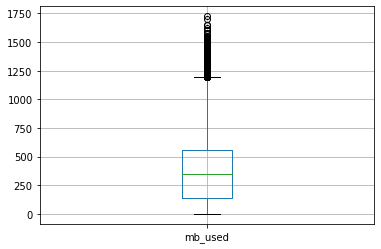

In [20]:
internet.boxplot('mb_used')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4689808490>]],
      dtype=object)

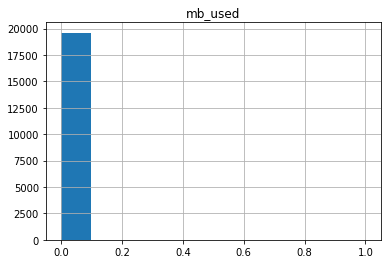

In [21]:
internet.hist('mb_used', range=(0,1))

Видим, что у нас есть почти 20 000 сеансов, за которые было израсходовано от 0.0 до 0.1 мб. Такие записи не обязательно являются ошибкой в данных: они могут быть результатом того, что пользователь вошел в интернет и тут же заблокировал телефон, передумал пользоваться или отвлекся. Посчитаем, какова доля таких записей, чтобы принять решение об их удалении или преобразовании.

In [22]:
print(len(internet.query('mb_used < 1')) / len(internet['mb_used']))

0.13185761332298054


13% всех выходов в интернет соответствуют минимальному расходу трафика. При этом мы знаем, что "Мегалайн" всегда округляет в большую сторону. Для веб-сеансов округляется не каждый сеанс, а израсходованный за месяц трафик. С учетом того, что такие сеансы распределены по всем 500 пользователям, можно предположить, что они очень слабо повлияют на итоговые расчеты. Сохраним их в неизменном виде. 

In [23]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Среднее значение использованных за сеанс мб - 370.1, медиана - 348. По ящику с усами видим, что значения около 1250 мб за сеанс и выше отнесены к выбросам, однако они могут появиться по вполне обычным причинам: возможно, кто-то посвятил сеанс просмотру фильма или длинного видеоролика. 

In [24]:
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

Нам уже было известно, что звонки с нулевой продолжительностью - пропущенные. Далее нас может устроить любая длина из имеющегося диапазона. 

Информация о звонках, количестве сообщений, трафике нам нужна по месяцам. Достанем месяцы из столбцов с датами (их нумерация соответствует общепринятой).

In [25]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [26]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [27]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

Нам нужна информация о платежах в месяц для каждого пользователя. Группируем таблицы calls, messages, internet по столбцам user_id и month, а затем объединяем их с помощью метода .merge(). 

In [28]:
calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
messages = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
internet = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()

In [29]:
data = calls.merge(
    messages,  how = 'outer', on = ['user_id', 'month']).merge(
    internet,  how = 'outer', on = ['user_id', 'month']).merge(
    users[['user_id', 'tariff', 'city']], how = 'left', on = 'user_id')
data.head()

,user_id,month,duration,id_x,id_y,mb_used,tariff,city
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар


In [30]:
# сделаем названия столбцов понятнее
data.columns = ['user_id', 'month', 'call_duration', 'call_quantity', 'message_quantity', 'mb_used', 'tariff_name', 'city']
data.head()

,user_id,month,call_duration,call_quantity,message_quantity,mb_used,tariff_name,city
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар


Оплата за интернет-трафик в "Мегалайне" происходит по гб, а не по мб, причем мб всегда округляются в большую сторону. Переведем мб в гб, создав отдельный столбец. 

In [31]:
data['gb_used'] = data['mb_used'] / 1024
data['gb_used'] = data['gb_used'].apply(np.ceil) # np.ceil позволяет округлить в большую сторону
data.head()

,user_id,month,call_duration,call_quantity,message_quantity,mb_used,tariff_name,city,gb_used
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар,3.0
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар,23.0
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар,14.0
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар,14.0
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар,15.0


Нам надо рассчитать помесячную выручку для каждого пользователя с учетом его тарифа и включенных туда платежей, а также перерасхода. Создаем таблицу data_tariffs, где к каждой строке подтянута информация о соответствующем тарифе.

In [32]:
# соединяем таблицы по столбцу tariff_name
data_tariffs = data.merge(tariffs, how='outer', on='tariff_name')
data_tariffs.head()

,user_id,month,call_duration,call_quantity,message_quantity,mb_used,tariff_name,city,gb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар,3.0,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар,23.0,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар,14.0,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар,14.0,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар,15.0,1000,30720,3000,1950,150,1,1


Для удобства дальнейшей работы переведем в гб информацию о включенном в абонентскую плату трафике. Столбцы с информацией в мб можно будет удалить, так как оплата происходит за гб, а не за мб.

In [33]:
data_tariffs['gb_included'] = (data_tariffs['mb_per_month_included'] / 1024).apply(np.ceil)
data_tariffs.head()

,user_id,month,call_duration,call_quantity,message_quantity,mb_used,tariff_name,city,gb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар,3.0,1000,30720,3000,1950,150,1,1,30.0
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар,23.0,1000,30720,3000,1950,150,1,1,30.0
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар,14.0,1000,30720,3000,1950,150,1,1,30.0
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар,14.0,1000,30720,3000,1950,150,1,1,30.0
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар,15.0,1000,30720,3000,1950,150,1,1,30.0


In [34]:
# удаляем лишние столбцы
del data_tariffs['mb_used']
del data_tariffs['mb_per_month_included']

In [35]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id              3214 non-null int64
month                3214 non-null int64
call_duration        3174 non-null float64
call_quantity        3174 non-null float64
message_quantity     2717 non-null float64
tariff_name          3214 non-null object
city                 3214 non-null object
gb_used              3203 non-null float64
messages_included    3214 non-null int64
minutes_included     3214 non-null int64
rub_monthly_fee      3214 non-null int64
rub_per_gb           3214 non-null int64
rub_per_message      3214 non-null int64
rub_per_minute       3214 non-null int64
gb_included          3214 non-null float64
dtypes: float64(5), int64(8), object(2)
memory usage: 401.8+ KB


Мы видим пропуски в столбцах, которые содержат информацию об использовании той или иной услуги: call_duration и call_quantity - это количество и продолжительность звонков за месяц, message_quantity - количество отправленных сообщений, gb_used - количество использованных гигабайт. Все эти столбцы в формате float. Это значит, что на месте пропусков указано NaN. 
Пропуски в указанных столбцах вероятнее всего возникли из-за того, что в указанный месяц пользователь не использовал данную услугу ни разу, то есть не звонил, не отправлял сообщений или не пользовался мобильным интернетом (последнее - реже всего). Такая ситуация кажется совершенно нормальной, особенно с учетом того, как распределились значения пропусков. Реже всего пользователи пренебрегают мобильным интернетом, а чаще всего - смс-сообщениями, которые сейчас все чаще игнорируются в пользу мессенджеров. Мы не будем удалять пропуски, но заменим их нулями для чистоты таблицы.  

In [36]:
data_tariffs = data_tariffs.fillna(0)

In [37]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id              3214 non-null int64
month                3214 non-null int64
call_duration        3214 non-null float64
call_quantity        3214 non-null float64
message_quantity     3214 non-null float64
tariff_name          3214 non-null object
city                 3214 non-null object
gb_used              3214 non-null float64
messages_included    3214 non-null int64
minutes_included     3214 non-null int64
rub_monthly_fee      3214 non-null int64
rub_per_gb           3214 non-null int64
rub_per_message      3214 non-null int64
rub_per_minute       3214 non-null int64
gb_included          3214 non-null float64
dtypes: float64(5), int64(8), object(2)
memory usage: 401.8+ KB


Теперь можно рассчитать, сколько за месяц платил каждый абонент в выборке. Для этого мы создадим функцию, которая будет сравнивать информацию о продолжительности звонков, количестве сообщений и расходе интернет-трафика в месяц для абонента с тем, что включено в тарифный план, считать стоимость дополнительных сообщений, гб и минут и складывать их с абонентской платой. 

In [38]:
def revenue_counter(data): # функция принимает в кач-ве аргумента датафрейм
    for i in data:
        counter = 0 # счетчик, в который добавляются оплаты
        if data['tariff_name'] == 'ultra': # оплата за тариф
            counter += 1950
        if data['tariff_name'] == 'smart':
            counter += 550
        if data['call_duration'] > data['minutes_included']: # оплаты сверх тарифа
            add_min = math.ceil(data['call_duration'] - data['minutes_included']) * data['rub_per_minute']
            counter += add_min
        if data['message_quantity'] > data['messages_included']:
            add_mess = (data['message_quantity'] - data['messages_included']) * data['rub_per_message']
            counter += add_mess
        if data['gb_used'] > data['gb_included']:
            add_gb = (data['gb_used'] - data['gb_included']) * data['rub_per_gb']
            counter += add_gb
    return counter # функция возвращает итоговый результат, сохраненный в счетчике

In [39]:
data_tariffs['revenue'] = data_tariffs.apply(revenue_counter, axis=1)
data_tariffs['revenue'] = data_tariffs['revenue'].astype('int')

In [40]:
# проверяем работу функции на строках, где использовано больше сообщений, чем включено в абон. плату
data_tariffs.query('message_quantity > messages_included').sample(5)

,user_id,month,call_duration,call_quantity,message_quantity,tariff_name,city,gb_used,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,revenue
1431,1100,12,578.0,68.0,63.0,smart,Санкт-Петербург,11.0,50,500,550,200,3,3,15.0,823
1289,1065,3,480.0,65.0,52.0,smart,Москва,20.0,50,500,550,200,3,3,15.0,1556
2868,1425,10,733.0,111.0,77.0,smart,Пермь,12.0,50,500,550,200,3,3,15.0,1330
1995,1217,8,600.0,84.0,86.0,smart,Ульяновск,13.0,50,500,550,200,3,3,15.0,958
1671,1149,10,261.0,35.0,77.0,smart,Мурманск,21.0,50,500,550,200,3,3,15.0,1831


### Вывод

На данном этапе мы собрали единую таблицу из представленных ранее данных и сделали необходимые рассчеты. Теперь у нас есть информация о том:
- сколько звонков каждый абонент из выборки делал в месяц;
- сколько минут разговора потратил каждый абонент в месяц;
- сколько сообщений отправил каждый абонент из выборки в месяц;
- сколько интернет-трафика в гб израсходовал каждый абонент из выборки в месяц;
- сколько в месяц платил каждый абонент из выборки;

Теперь можно приступать к аналитической части. 

## Анализ данных

Теперь исходя из имеющихся данных рассмотрим, сколько минут разговора, сообщений и гб интернет-трафика требуется пользователям каждого тарифа в месяц. Рассчитаем среднее, дисперсию и стандартное отклонение для интересующих нас параметров, построим необходимые графики. 

In [41]:
# необходимые расчеты делаем в сводной таблице
tariffs_pivot = data_tariffs.pivot_table(
    columns='tariff_name', 
    values=['call_duration', 'message_quantity', 'gb_used', 'revenue'], 
    aggfunc=['mean', np.std, np.var])
tariffs_pivot

mean                      std              \
tariff_name             smart        ultra       smart       ultra   
call_duration      417.934948   526.623350  190.313730  317.606098   
gb_used             16.328847    19.494416    5.747061    9.853511   
message_quantity    33.384029    49.363452   28.227876   47.804457   
revenue           1289.973531  2070.152284  818.404367  376.187114   

                            var                 
tariff_name               smart          ultra  
call_duration      36219.315784  100873.633397  
gb_used               33.028705      97.091686  
message_quantity     796.812958    2285.266143  
revenue           669785.708006  141516.745079

In [42]:
tariffs['gb_included'] = tariffs['mb_per_month_included'] / 1024
tariffs['gb_included'] = tariffs['gb_included'].apply(np.ceil)
del tariffs['mb_per_month_included']

In [43]:
tariffs

,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_included
0,50,500,550,200,3,3,smart,15.0
1,1000,3000,1950,150,1,1,ultra,30.0


Видим, что средняя *продолжительность звонков* в месяц на тарифах Смарт и Ультра - 419 и 545 минут со стандартным отклонением 189.3 и 306.9 соответственно; 
среднее количество *используемых гигабайт* - 16 и 20 со стандартным отклонением 5.7 и 9.7 соответственно; 
среднее количество *сообщений* - 38 и 61 со стандартным отклонением 26.7 и 45.9 соответственно. 
Средний пользователь укладывается в количество минут и сообщений, которые входят в тарифный план, а среднему пользователю тарифа Ультра также хватает включенных в тарифный план гигабайт. Среднему пользователю тарифа Смарт 15гб не хватает и он доплачивает за дополнительные гб. 

Посмотрим, как распределены данные. Построим гистограммы для тарифов Смарт и Ультра. Гистограммы по одной характеристике будем строить на одном графике, чтобы увидеть их в сравнении. 

In [44]:
# создаем функцию, которая будет строить нужные нам гистограммы
# в качестве аргумента функция принимает название колонки и заголовок графика
# функцию можно запустить циклом, однако мы хотим получить графики в отдельных ячейках
# так будет удобнее анализировать каждую из характеристик
def compare_hist(column, title):
    ax1 = data_tariffs.query(
        'tariff_name == "smart"')[column].hist(label='Smart', alpha=0.6)
    ax2 = data_tariffs.query(
        'tariff_name == "ultra"')[column].hist(label='Ultra', alpha=0.6)
    ax1.set_title(title)
    ax1.legend()
    ax2.legend()
    plt.show()

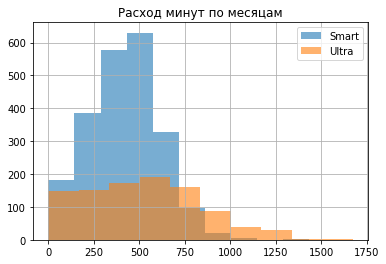

In [45]:
compare_hist('call_duration', 'Расход минут по месяцам')

Распределение расхода минут тяготеет к нормальному, графики скошены влево. Пиковые значения для обоих тарифов - около 500 минут. Далее для тарифа Смарт график резко меняется: кажется, что многие его пользователи выходят за отведенные 500 минут разговора, однако редко превышают лимит более чем на 100 минут. Пользователи тарифа Ультра не расходуют полностью отведенные тарифным планом минуты и не доплачивают за дополнительные. Более того, обычно они общаются по телефону не сильно дольше пользователей тарифа Смарт. 

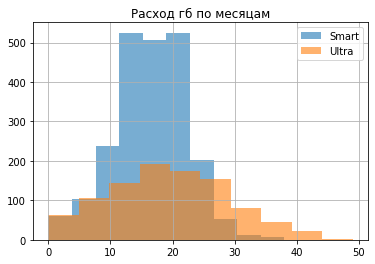

In [46]:
compare_hist('gb_used', 'Расход гб по месяцам')

Распределение расхода гб тяготеет к нормальному. При этом чаще всего пользователи тарифа Ультра укладываются во включенные 30гб интернета, а пользователи тарифа Смарт практически так же часто превышают его, как и не превышают. При этом стоимость дополнительного гб для пользователей тарифа Смарт дороже, чем для пользователей тарифа Ультра.

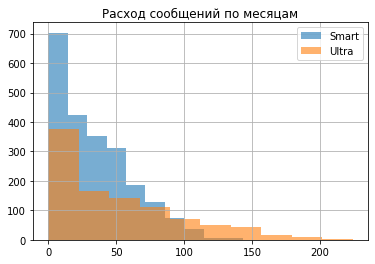

In [47]:
compare_hist('message_quantity', 'Расход сообщений по месяцам')

Диаграмма расхода сообщений по месяцам больше похожа на распределение Пуассона, чем на нормальное распределение. Видно, что даже самые активные пользователи тарифа Ультра отправляют почти в пять раз меньше сообщений, чем включено в их тарифный план, а пользователям тарифа Смарт снова иногда приходится доплачивать, однако эта потребность возникает намного реже, чем потребнность доплаты за дополнительный гб. 

### Вывод

Средний пользователь тарифа "Смарт" чаще доплачивает за дополнительные услуги, чем пользователь тарифа "Ультра", но пользователи тарифа "Ультра" в среднем все равно платят больше. Пользователи тарифа "Ультра" при этом крайне редко полностью расходуют минуты, сообщения и гигабайты.

## Проверка гипотез

Наша задача: проверить две нулевые и две альтернативные гипотезы. 

### Средняя выручка: разные тарифы

**Нулевая гипотеза:** средняя выручка пользователей тарифов Смарт и Ультра не различется. 

**Альтернативная гипотеза:** средняя выручка пользователей тарифов Смарт и Ультра различается. 

Мы уже строили сводную таблицу по тарифам. Мы также заранее указали в ней параметр revenue. Снова обратимся к этой таблице.

In [48]:
tariffs_pivot

mean                      std              \
tariff_name             smart        ultra       smart       ultra   
call_duration      417.934948   526.623350  190.313730  317.606098   
gb_used             16.328847    19.494416    5.747061    9.853511   
message_quantity    33.384029    49.363452   28.227876   47.804457   
revenue           1289.973531  2070.152284  818.404367  376.187114   

                            var                 
tariff_name               smart          ultra  
call_duration      36219.315784  100873.633397  
gb_used               33.028705      97.091686  
message_quantity     796.812958    2285.266143  
revenue           669785.708006  141516.745079

Видим, средняя плата за тариф Смарт более чем в два раза превышает абонентскую плату, в то время как средний пользователь тарифа Ультра доплачивает всего 120 рублей. 
Средняя выручка с пользователя в месяц за тариф Смарт: 1290 рублей.
Средняя выручка с пользователя в месяц за тариф Ультра: 2070 рублей. 
Разница: 780 рублей. 

In [49]:
# сформируем два массива с выборками: оплата пользователей по месяцам для разных тарифов
smart_revenue = data_tariffs.query('tariff_name == "smart"')['revenue']
ultra_revenue = data_tariffs.query('tariff_name == "ultra"')['revenue']

In [50]:
alpha=0.05
# указываем параметр equal_var=False, т.к. рассчитанная дисперсия для двух массивов сильно отличается 
result1 = st.ttest_ind(smart_revenue, ultra_revenue, equal_var=False)
p_value1 = result1.pvalue

if p_value1 < alpha:
    print('Нулевую гипотезу можно отвергнуть')
else:
    print('Нулевую гипотезу нельзя отвергнуть')

Нулевую гипотезу можно отвергнуть


In [51]:
p_value1

4.2606313931076085e-250

#### Вывод

Среднее значение выручки с пользователя в месяц за тариф Смарт на 780 рублей меньше, чем среднее значение выручки с пользователя в месяц за тариф Ультра. Значение p-value меньше заданного порогового значения alpha.
Таким образом, можно отвергнуть нулевую гипотезу, что средняя выручка пользователей тарифов Смарт и Ультра не различется. **Оснований отвергнуть альтернативную гипотезу, что средняя выручка пользователей тарифов Смарт и Ультра различается, у нас нет.**

### Средняя выручка: Москва и регионы

**Нулевая гипотеза:** средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

**Альтернативная гипотеза:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [52]:
# сформируем два массива с выборками: оплата по месяцам пользователей из разных регионов
moscow_revenue = data_tariffs.query('city == "Москва"')['revenue']
regions_revenue = data_tariffs.query('city != "Москва"')['revenue']

In [53]:
print('Средняя оплата в месяц абонентов из Москвы:', moscow_revenue.mean())
print('Средняя оплата в месяц абонентов из регионов:', regions_revenue.mean())
print('Разница:', (moscow_revenue.mean() - regions_revenue.mean()))

Средняя оплата в месяц абонентов из Москвы: 1546.7135842880523
Средняя оплата в месяц абонентов из регионов: 1524.9362274298885
Разница: 21.777356858163785


Видим, что разница в данном случае не такая большая, как между платами за тарифы Смарт и Ультра: всего 22 рубля. Также сравним дисперсии:

In [54]:
print('Дисперсия массива с данными по Москве', np.var(moscow_revenue, ddof=1)) # ddof=1, т.к оцениваем по выборке
print('Дисперсия массива с данными по регионам', np.var(regions_revenue, ddof=1))

Дисперсия массива с данными по Москве 565636.467011886
Дисперсия массива с данными по регионам 654137.6285218114


In [55]:
result2 = st.ttest_ind(moscow_revenue, regions_revenue)
p_value2 = result2.pvalue

if p_value2 < alpha:
    print('Нулевую гипотезу можно отвергнуть')
else:
    print('Нулевую гипотезу нельзя отвергнуть')

Нулевую гипотезу нельзя отвергнуть


#### Вывод

Средняя оплата абонентов из Москвы в месяц всего на 22 рубля больше, чем в регионах. Значение p_value больше заданного порогового значения alpha. Таким образом, мы не можем отвергнуть нулевую гипотезу о том, что **средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.** Данных в пользу того, что альтернативная гипотеза верна, у нас нет. 

## Общий вывод: какой тариф выгоднее продвигать?

Средняя выручка пользователей тарифов Смарт и Ультра различается. Пользователи тарифа Ультра в среднем платят больше, однако им нечасто приходится доплачивать за услуги сверх абонентской платы. Пользователи тарифа Смарт в среднем платят более чем в два раза больше, чем абонентская плата: чаще всего им не хватает гб интернета. При этом на такие доплаты стабильно нельзя рассчитывать. 

**Нам кажется, что выгоднее всего продвигать тариф "Ультра".** Пользователи этого тарифа обеспечивают "Мегалайну" более высокие и при этом регулярно высокие оплаты, в то же время они редко пользуются полным пакетом услуг, что делает более дорогой ту долю услуг, которой они пользуются. 

При этом возможно у многих пользователей тарифа "Смарт" есть потребность, которую "Мегалайну" пока не удается удовлетворить: кажется, что пользователи нуждаются в альтернативном тарифе, где было бы больше гб интернета. Возможно, такой тариф смог бы обеспечить мегалайну более высокую *стабильную* прибыль от клиентов, которым сейчас периодически приходится доплачивать за дополнительные гб, а также помог бы избежать ухода раздраженных доплатами клиентов к другим операторам. 